# LSTM/QK-VQE

In [2]:
## basis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## random
import random
import math
from typing import List, Callable, Tuple
## ML
import torch 
import torch.nn as nn
import torch.optim as optim 
from scipy.optimize import minimize
## QML
import h5py
import pennylane as qml
from pennylane import qchem
## access file 
import os 

In [3]:
torch.manual_seed(42)
np.random.seed(42)
qml.math.random.seed(42)

## Model

In [8]:
class molecule_data:
    def __init__(self, molecule_list, ):
        self.molecule_list = molecule_list
    
    @staticmethod
    def load_data(molecule, basis = "STO-3G", folder_path = "./datasets/"):
        data_list = []

        print("\n--- Starting Load Data ---")
        for mol_name, bondlengths in molecule:
            if bondlengths is None:
                data = qml.data.load("qchem", molname = mol_name, basis = basis, folder_path = folder_path)
            else:
                data = qml.data.load("qchem", molname = mol_name, basis = basis,folder_path = folder_path, bondlength = bondlengths)

            for entry in data:
                data_list.append(entry)

        df = pd.DataFrame(data_list)
        print(df.head())
        return df
    
    @staticmethod 
    def data_params(df, train_split_index):
        # define max qubits

        max_qubits = 0

        for i in range(len(df[0])):
            if len(df[0][i].hf_state) > max_qubits:
                max_qubits = len(df[0][i].hf_state)
        
        # find the max params need for single and double
        max_s_params = 0
        max_d_params = 0

        for data in df[0]:
            electrons = sum(data.hf_state)
            orbitals = len(data.hf_state)

            single, double = qchem.excitations(electrons, orbitals)
            s_w, d_w = qml.qchem.excitations_to_wires(single, double)
            num_single = len(s_w)
            num_double = len(d_w)
            max_total_params = max(max_s_params, num_single) + max(max_d_params, num_double)
        
        df_list = list(df[0])
        train_set = df_list[:train_split_index]
        test_set = df_list[train_split_index:]
        
        return max_qubits, max_total_params, train_set, test_set


In [9]:
class VQE:
    def __init__(self, data_entry, max_qubits):
        self.data = data_entry
        self.max_qubits = max_qubits

        self.wires = range(self.max_qubits)
        self.orbitals = len(self.data.hf_state)
        self.electrons = sum(self.data.hf_state)
        self.singles, self.doubles = qchem.excitations(self.electrons, self.orbitals)
        self.s_wires, self.d_wires = qml.qchem.excitations_to_wires(self.singles, self.doubles)
        self.num_single = len(self.s_wires)
        self.num_double = len(self.d_wires)
        self.total_vqe_params = self.num_single + self.num_double

        self.device = qml.device("lightning.qubit", wires = self.wires)
        self.qnode = qml.QNode(self.ansatz, self.device, interface = "torch", diff_method = "adjoint")

    def ansatz(self, params):

        #params = torch.cat([single_params[:self.num_single], double_params[:self.num_double]], dim = 0)
        uccsd_params = params.squeeze(0)[:self.total_vqe_params]
        qml.UCCSD(uccsd_params, wires = range(self.orbitals), s_wires = self.s_wires, d_wires = self.d_wires, init_state = self.data.hf_state)

        return qml.expval(self.data.hamiltonian)
        
        
    def get_loss_function(self):
            
        return lambda theta: self.qnode(theta)

class VQEOptimizer:
    def __init__(self, vqe_problem:VQE):
        self.vqe_problem = vqe_problem
        self.cost_function = vqe_problem.get_loss_function()

    def run_optimization(self, initial_params, optimizer = 'Adam', max_iter = 500, learning_rate = 0.01, conv_tol = 1e-6):
        params = torch.tensor(initial_params, requires_grad= True, dtype = torch.float32)

        if optimizer == 'ADAM':
            opt = optim.Adam([params], lr = learning_rate)
            
        elif optimizer == 'SGD':
            opt = optim.SGD([params], lr = learning_rate)
            
        energy_history = [self.cost_function(params).item()]
        param_history = [params.detach().clone()]
        conv_iter = max_iter
        
        print("\n--- Starting VQE Optimization ---")

        for iteration in range(max_iter):
            opt.zero_grad()
            energy = self.cost_function(params)
            energy.backward()
            opt.step()

            param_history.append(params.detach().clone())
            energy_history.append(energy.item())

            if (iteration+1)%50 == 0:
                print(f"Step = {iteration+1}/{max_iter}, Energy = {energy_history[-1]:.8f} Ha")
            if iteration > 0:
                conv = abs(energy_history[-1] - energy_history[-2])
                if conv <= conv_tol:
                    conv_iter = iteration + 1
                    print(print(f"  Convergence reached at step {conv_iter}"))
                    break
        
        print(f"Optimization finished, final energy: {energy_history[-1]:.8f} Ha")
        return conv_iter, param_history[-1], energy_history[-1], param_history, energy_history

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_feature_dim, max_total_params, max_qubits=0, loss_function_type = "weighted"):
        super(LSTM, self).__init__()
        self.input_feature_dim = input_feature_dim
        #self.num_rnn_iteration = num_rnn_iteration
        self.max_total_params = max_total_params
        self.max_qubits = max_qubits
        self.loss_function_type = loss_function_type
        self.lstm = nn.LSTM(input_size = input_feature_dim + 1 , hidden_size = input_feature_dim, num_layers = 1, batch_first = True)
        self.mapping = nn.Linear(input_feature_dim, max_total_params, bias = False)
        #self.activation = nn.Tanh()

    def forward(self, molecule_cost, num_rnn_iteration, intermediate_steps = False):
        current_cost = torch.zeros((1, 1), dtype = torch.float32)
        current_params = torch.zeros((1, self.input_feature_dim), dtype = torch.float32)
        current_h = torch.zeros((self.lstm.num_layers, 1, self.input_feature_dim), dtype = torch.float32)
        current_c = torch.zeros((self.lstm.num_layers, 1, self.input_feature_dim), dtype = torch.float32)
        #inputs = [initial_cost, initial_params, initial_h, initial_c]

        param_outputs = []
        cost_outputs = []

        for i in range(num_rnn_iteration):
            #current_cost, current_params, current_h, current_c = inputs

            new_input = torch.cat([current_cost, current_params], dim = 1).unsqueeze(1)
            new_params, (new_h, new_c) = self.lstm(new_input, (current_h, current_c))
            new_params = new_params.squeeze(1)

            #params = self.activation(self.mapping(new_params))
            params = self.mapping(new_params.squeeze(1))

            _cost = molecule_cost(params.squeeze(0))
            new_cost = _cost.view(1,1).float()

            param_outputs.append(params)
            cost_outputs.append(new_cost)
 
            current_cost = new_cost
            current_params = new_params
            current_h = new_h
            current_c = new_c
        
        loss = 0.0

        if self.loss_function_type == "weighted":
            for t in range(len(cost_outputs)):
                coeff = 0.1*(t+1)
                loss += cost_outputs[t]*coeff
            loss = loss/len(cost_outputs)

        elif self.loss_function_type == "descent":
            cost = torch.stack(cost_outputs)
            for t in range(1, len(cost_outputs)):
                f_j = torch.min(cost[:t])
                min = torch.min((cost[t]-f_j), torch.tensor(0.0))
                loss += min 
            loss = loss/len(cost_outputs)

        if intermediate_steps:
            return param_outputs, loss
        else:
            return loss    
        
class ModelTrain:
    def __init__(self, model, lr_lstm = 0.01, lr_mapping = 0.01, num_rnn_iteration = 5):
        self.model = model
        self.lr_lstm = lr_lstm
        self.lr_mapping = lr_mapping
        self.num_rnn_iteration = num_rnn_iteration

        learning_rate = [
            {'params':self.model.lstm.parameters(), 'lr': self.lr_lstm},
            {'params':self.model.mapping.parameters(), 'lr': self.lr_mapping}
        ]
        self.optimizer = optim.Adam(learning_rate)

    def train_step(self, loss_qnode, num_rnn_iteration):
        self.optimizer.zero_grad()
        loss = self.model(loss_qnode, num_rnn_iteration)
        loss.backward()
        self.optimizer.step()

        return loss
    
    def train(self, train_data, epochs = 5, steps_per_epoch = 5, conv_tol_lstm = 1e-5):
        self.model.train()
        previous_mean_loss = None
        
        print("\n--- Starting LSTM Model Training ---")
        for epoch in range(epochs):
            if epoch%1 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
            
            epoch_loss = []
            for i, molecule_data in enumerate(train_data):
                molecule_cost = VQE(molecule_data, self.model.max_qubits)
                loss_qnode = molecule_cost.get_loss_function()
                loss = self.train_step(loss_qnode, self.num_rnn_iteration)
                epoch_loss.append(loss.item())

                if (i+1) % 10 == 0:
                    print(f" > Molecule {i+1}/{len(train_data)} - Loss: {loss.item():.8f}")
            
            #epoch_loss = np.array(epoch_loss)
            mean_loss = np.mean(epoch_loss)

            if (epoch+1)%10 == 0:
                print(f"Epoch {epoch+1} Mean loss: {mean_loss:.8f}")
            if previous_mean_loss is not None:
                change = (previous_mean_loss - mean_loss)/(abs(previous_mean_loss))
                if change <= conv_tol_lstm:
                    print(f"Traning converged at epoch {epoch+1}")
                    break
            
            previous_mean_loss = mean_loss
    
    def evaluate(self, molecule_cost, num_rnn_iteration = 5):
        self.model.eval()
        print("\n--- Starting LSTM Model Testing ---")
        with torch.no_grad():      
            params, loss = self.model(molecule_cost, num_rnn_iteration, intermediate_steps = True)

        lstm_guesses = [p.squeeze(0) for p in params]
        lstm_energies = [molecule_cost(guess).item() for guess in lstm_guesses]

        return lstm_guesses, lstm_energies

## Result


--- Starting Load Data ---
                                                   0
0  <Dataset = molname: H2, basis: STO-3G, bondlen...
1  <Dataset = molname: H2, basis: STO-3G, bondlen...
2  <Dataset = molname: H2, basis: STO-3G, bondlen...
3  <Dataset = molname: H2, basis: STO-3G, bondlen...
4  <Dataset = molname: H2, basis: STO-3G, bondlen...
Train set[<Dataset = molname: H2, basis: STO-3G, bondlength: 0.5, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.54, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.58, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.62, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.66, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.82, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.86, attrib

/var/folders/k_/fh5hn8ms70jchh82ljqpdzc80000gn/T/ipykernel_13187/2838194272.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad= True, dtype = torch.float32)



--- Starting VQE Optimization ---
  Convergence reached at step 45
None
Optimization finished, final energy: -2.18026471 Ha

--- Starting VQE Optimization ---
Step = 50/500, Energy = -1.90636575 Ha
Step = 100/500, Energy = -2.17770696 Ha
  Convergence reached at step 132
None
Optimization finished, final energy: -2.18036079 Ha

--- Starting VQE Optimization ---
  Convergence reached at step 44
None
Optimization finished, final energy: -2.18027997 Ha

--- Simulation Complete ---

--- Saving Complete ---
Result of VQE Optimization


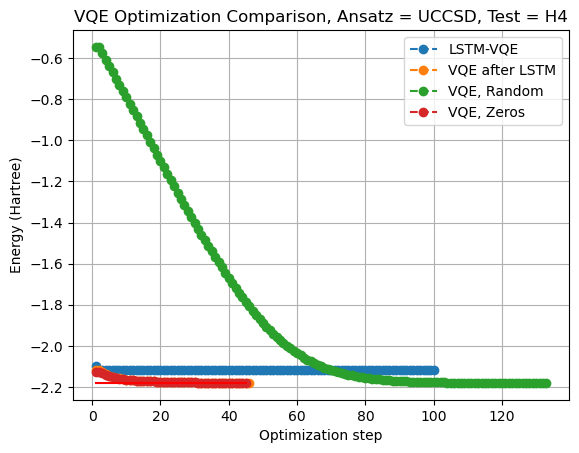

Result of Erros


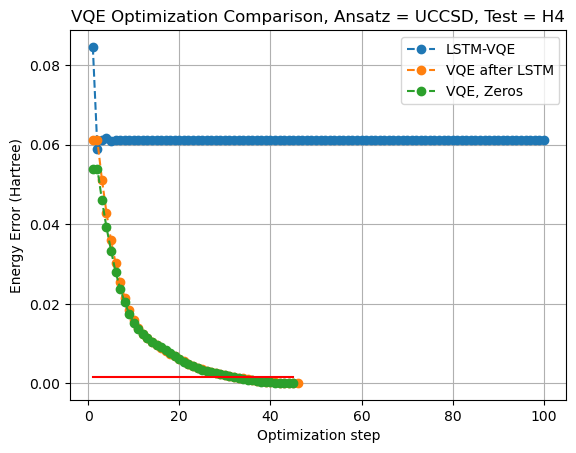

In [11]:
if __name__ == "__main__":
    # ---Hyperparameters ---
    ## LSTM
    ### opt for LSTM train: Adam
    fixed_param_dim = 40
    lr_lstm = 0.01
    lr_mapping = 0.1
    epochs = 5
    steps_per_epoch = 5
    conv_tol_lstm = 1e-6 
    loss_type = "weighted"
    steps_recurrent_loop_train = 5 # for train
    steps_recurrent_loop_test = 100 # for test

    ## VQE
    lr_vqe = 0.01
    max_iter_vqe = 500
    conv_tol_vqe = 1e-6
    vqe_optimizer = "ADAM"
    
    # Data set 
    molecule = [
        ("H2", [0.5]),
        ("H2", [0.54]),
        ("H2", [0.58]),
        ("H2", [0.62]),
        ("H2", [0.66]),
        ("H2", [0.82]),
        ("H2", [0.86]),
        ("H2", [0.9]),
        ("H2", [0.94]),
        ("H2", [0.98]),
        ("H2", [1.02]),
        ("H2", [1.06]),
        ("H2", [1.1]),
        ("H2", [1.14]),
        ("H2", [1.18]),
        ("H2", [1.22]),
        ("H2", [1.26]),
        ("H2", [1.3]),
        ("H2", [1.34]),
        ("H2", [1.38]),
        ("H2", [1.42]),
        ("H2", [1.46]),
        ("H2", [1.5]),
        ("H2", [1.54]),
        ("H2", [1.58]),
        ("H2", [1.62]),
        ("H2", [1.66]),
        ("H2", [1.7]),
        ("H2", [1.74]),
        ("H2", [1.78]),
        ("H2", [1.82]),
        ("H2", [1.86]),
        ("H2", [1.9]),
        ("H2", [1.94]),
        ("H2", [1.98]),
        ("H2", [2.02]),
        ("H2", [2.06]),
        ("H2", [2.1]),
        ("H3+", [0.5]),
        ("H3+", [0.54]),
        ("H3+", [0.58]),
        ("H3+", [0.62]),
        ("H3+", [0.66]),
        ("H3+", [0.7]),
        ("H3+", [0.74]),
        ("H3+", [0.78]),
        ("H3+", [0.82]),
        ("H3+", [0.86]),
        ("H3+", [0.9]),
        ("H3+", [0.94]),
        ("H3+", [0.98]),
        ("H3+", [1.02]),
        ("H3+", [1.06]),
        ("H3+", [1.1]),
        ("H3+", [1.26]),
        ("H3+", [1.3]),
        ("H3+", [1.34]),
        ("H3+", [1.38]),
        ("H3+", [1.42]),
        ("H3+", [1.46]),
        ("H3+", [1.5]),
        ("H3+", [1.54]),
        ("H3+", [0.5]),
        ("H2", None),
        ("H3+", None),
        ("H4", None)
        ]
   
    train_split_index = 65
    # Save File Path
    Data_save_path = "./datasets/"
    Model_save_path = "lstm_model_no_tanh.pth"
    Results_save_path = "model_result_no_tanh.csv"

    
    # load data from pennylane dataset if you have no data 
    dataset = molecule_data.load_data(molecule, basis = "STO-3G", folder_path = Data_save_path)
    # If you have data in your computer
   
    max_qubits, max_params, train_set, test_set = molecule_data.data_params(df = dataset, train_split_index = train_split_index)
    print(f"Train set{train_set}")
    print(f"Test set{test_set}")
 
    # --- LSTM Model Training (or Loading) ---
    alpha_model = LSTM(input_feature_dim = fixed_param_dim,
                        max_total_params = max_params, 
                        max_qubits = max_qubits,
                        loss_function_type = loss_type
                        )
    
    trainer = ModelTrain(alpha_model, 
                         lr_lstm = lr_lstm, 
                         lr_mapping= lr_mapping,
                         num_rnn_iteration = steps_recurrent_loop_train)
    
    # train model
    print("\n--- Training LSTM Model ---")
    
    trainer.train(train_set, 
                  epochs = epochs, 
                  steps_per_epoch = steps_per_epoch, 
                  conv_tol_lstm = conv_tol_lstm)
    
    torch.save(alpha_model.state_dict(), Model_save_path)
    print("Model saved successfully!")
    
    print("\n--- Evaluating LSTM Model ---")

    for i, molecule_data in enumerate(test_set):
        molecule_cost = VQE(molecule_data, max_qubits)
        loss_qnode = molecule_cost.get_loss_function()
        predicted_params_list, predicted_energies_list = trainer.evaluate(
            molecule_cost = loss_qnode, 
            num_rnn_iteration = steps_recurrent_loop_test)
        
        print(f"LSTM predicted energies:{predicted_energies_list}")

        # use lstm output as initial params for VQE to optimize
        test_vqe = VQE(molecule_data, max_qubits)
        opt_lstm_vqe = VQEOptimizer(test_vqe)
        conv_iter_lstm, final_params_lstm, final_energy_lstm, params_history_lstm, energy_history_lstm = opt_lstm_vqe.run_optimization(
            initial_params = predicted_params_list[-1],
            optimizer = vqe_optimizer, 
            max_iter = max_iter_vqe,
            learning_rate = lr_vqe,
            conv_tol = conv_tol_vqe
        )
    
# VQE predict without guess by lstm 
for i, molecule_data in enumerate(test_set):
    # random params
    params_rand = torch.rand(max_params, dtype = torch.float32)
    vqe_test_rand = VQE(molecule_data, max_qubits)
    opt_rand_vqe = VQEOptimizer(vqe_test_rand)
    conv_iter_rand, final_params_rand, final_energy_rand, params_history_rand, energy_history_rand = opt_rand_vqe.run_optimization(
            initial_params = params_rand,
            optimizer = vqe_optimizer, 
            max_iter = max_iter_vqe,
            learning_rate = lr_vqe,
            conv_tol = conv_tol_vqe
        )
    # params which all zeros
    params_zeros = torch.zeros(max_params, dtype = torch.float32)
    vqe_test_zeros = VQE(molecule_data, max_qubits)
    opt_zeros_vqe = VQEOptimizer(vqe_test_zeros)
    conv_iter_zeros, final_params_zeros, final_energy_zeros, params_history_zeros, energy_history_zeros = opt_rand_vqe.run_optimization(
            initial_params = params_zeros,
            optimizer = vqe_optimizer, 
            max_iter = max_iter_vqe,
            learning_rate = lr_vqe,
            conv_tol = conv_tol_vqe
        )

print("\n--- Simulation Complete ---")

result_data = {
    'LSTM-VQE': pd.Series(predicted_energies_list),
    'VQE after LSTM':pd.Series(energy_history_lstm),
    'VQE Random': pd.Series(energy_history_rand), 
    'VQE Zeros': pd.Series(energy_history_zeros)
}

df_result = pd.DataFrame(result_data)
df_result.to_csv(Results_save_path, index = False)
print("\n--- Saving Complete ---")
print("Result of VQE Optimization")
E_fci = test_set[0].fci_energy
#plt.figure(figsize = (20,10))
plt.plot(range(1, len(predicted_energies_list) + 1), predicted_energies_list, marker='o', label='LSTM-VQE', ls="dashed")
plt.plot(range(1, len(energy_history_lstm) + 1), energy_history_lstm, marker='o', label='VQE after LSTM', ls="dashed")
plt.plot(range(1, len(energy_history_rand) + 1), energy_history_rand, marker='o', label='VQE, Random', ls="dashed")
plt.plot(range(1, len(energy_history_zeros) + 1), energy_history_zeros, marker='o', label='VQE, Zeros', ls="dashed")
plt.plot(range(1, len(energy_history_zeros) + 1), np.full(len(energy_history_zeros) , E_fci), color="red")
plt.xlabel("Optimization step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Optimization Comparison, Ansatz = UCCSD, Test = H4")
plt.legend()
plt.grid(True)
plt.show()

print("Result of Erros")
#plt.figure(figsize = (20,10))
plt.plot(range(1, len(predicted_energies_list) + 1), [item-E_fci for item in predicted_energies_list], marker='o', label='LSTM-VQE', ls="dashed")
plt.plot(range(1, len(energy_history_lstm) + 1), [item-E_fci for item in energy_history_lstm], marker='o', label='VQE after LSTM', ls="dashed")
#plt.plot(range(1, len(energy_history_rand) + 1), [item-E_fci for item in energy_history_rand], marker='o', label='VQE, Random', ls="dashed")
plt.plot(range(1, len(energy_history_zeros) + 1), [item-E_fci for item in energy_history_zeros], marker='o', label='VQE, Zeros', ls="dashed")
plt.plot(range(1, len(energy_history_zeros) + 1), np.full(len(energy_history_zeros) , 0.0016), color="red")
plt.xlabel("Optimization step")
plt.ylabel("Energy Error (Hartree)")
plt.title("VQE Optimization Comparison, Ansatz = UCCSD, Test = H4")
plt.legend()
plt.grid(True)
plt.show()